In [1]:
from os.path import join
import pandas as pd
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
DIR = "/data/NewsGuard/"
FIGURES = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
TABLES = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

In [3]:
# merged snapshots twice per (at the beginning and end of each month)
# see merge strategy in merge_snapshots.ipynb
# sampled only from the middle of the month
df_15 = pd.read_csv(join(DIR, "newsguard_mid_month.csv"),
                    parse_dates=["file_date"],
                    low_memory=False)

# most recent version of newsguard database
df_recent = pd.read_csv(join(DIR, "newsguard_recent_version.csv"),
                    low_memory=False)

In [4]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    sns.despine(ax=ax)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

## How many topic labels are there?

In [5]:
print(
    f'Out of {len(df_recent)} ratings, '
    f'there are {df_recent["Topics"].isnull().sum()} without topic. ')

print(
    f'This makes up {round(df_recent["Topics"].isnull().sum()/len(df_recent)*100,2)}% ')

Out of 12288 ratings, there are 352 without topic. 
This makes up 2.86% 


In [6]:
df_15\
    .groupby("file_date")["Topics"]\
    .count()\
    .head(10)

file_date
2019-03-15 01:00:00      0
2019-04-15 01:00:00      0
2019-05-15 01:00:00      0
2019-06-15 01:00:00      0
2019-07-15 01:00:00      0
2019-08-15 01:00:00      0
2019-09-15 01:00:00      0
2019-10-15 01:00:00      4
2019-11-15 01:00:00     83
2019-12-15 01:00:00    283
Name: Topics, dtype: int64

In [7]:
recent_topics_df = \
    df_recent[[
        "Domain", "Country", "Topics",
        "Orientation", "Score", "Rating"]]

recent_topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

recent_topics_df["Topics"] = \
    df_recent["Topics"]\
        .str.split(",")  #split topics into lists

#recent_topics_df.head(3)

In [8]:
# explode topics into separate rows
recent_topics_df = \
    recent_topics_df\
        .explode("Topics")\
        .reset_index(drop=True)

# capitalize first letter of each topic
recent_topics_df["Topics"] = \
    recent_topics_df["Topics"].str.capitalize()

# replace some topics with shorter names
recent_topics_df["Topics"] = recent_topics_df["Topics"]\
    .replace({"Conspiracy theories or hoaxes": "Conspiracies",
              "Sports and athletics": "Sports",
                "Covid-19 misinformation": "COVID-19 misinfo",
                "Health or medical information": "Health news",
                "Political news or commentary": "Political news",
                "Business or personal finance": "Business"})

#recent_topics_df.head(3)

In [9]:
# count of each topic
recent_topic_count = \
    recent_topics_df\
        .groupby("Topics")\
        .size()\
        .reset_index()

# percentage of each topic
recent_topic_count["%"] = \
    (recent_topic_count[0] / len(df_recent) * 100)\
        .round(2)

# rename columns
recent_topic_count\
    .columns = ["Topics", "Count", "%"]

# aggregate score and sd
recent_topic_avg = \
    recent_topics_df\
        .groupby("Topics")["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

# rename columns
recent_topic_avg\
    .columns = ["Topics", "Score", "SD"]

# merge based on topic
recent_topic_desc = \
    pd.merge(recent_topic_count,
             recent_topic_avg,
            on="Topics")

# show the most popular topics
recent_topic_desc\
    .sort_values(by="Count",
                 ascending=False)\
    .head(5)

,Topics,Count,%,Score,SD
11,Local news,4952,40.30,75.23,25.90
14,Political news,4857,39.53,41.69,30.80
7,General news,2785,22.66,74.84,27.52
8,Health news,1667,13.57,39.34,35.44
2,Conspiracies,1576,12.83,12.63,12.61


In [10]:
# show the topics with worst score
recent_topic_desc\
    .sort_values(by="Score",
                 ascending=True)\
    .head(5)

,Topics,Count,%,Score,SD
2,Conspiracies,1576,12.83,12.63,12.61
12,Military and defense,197,1.60,31.77,34.87
8,Health news,1667,13.57,39.34,35.44
14,Political news,4857,39.53,41.69,30.80
15,Religion,137,1.11,64.75,28.17


In [11]:
# show the topics with highest score
recent_topic_desc\
    .sort_values(by="Score",
                 ascending=False)\
    .head(5)

,Topics,Count,%,Score,SD
3,Education,62,0.50,85.75,16.87
0,Business,625,5.09,81.39,19.90
18,Technology,412,3.35,77.68,24.43
6,Fashion,130,1.06,76.49,10.17
10,Lifestyle,465,3.78,76.12,13.38


In [12]:
# get a list of domains with rating N
bad_domains = df_recent\
    [df_recent["Rating"] == "N"]\
    ["Domain"].unique()

len(bad_domains)

4195

In [13]:
# extract topics shared by bad domains
topics_ratings = recent_topics_df\
        .groupby(["Topics", "Rating"])["Domain"]\
        .nunique()\
        .unstack(fill_value=0)\
        .reset_index()\
        .sort_values(by="N", ascending=False)

# add percentage of good vs bad sharing the topic
topics_ratings["% N"] = \
    (topics_ratings["N"] / len(bad_domains) * 100)\
        .round(1)

topics_ratings

Rating,Topics,FL,N,P,S,T,% N
14,Political news,30,3315,16,3,1012,79.0
2,Conspiracies,1,1365,14,0,9,32.5
11,Local news,11,1275,1,2,3183,30.4
8,Health news,84,934,16,2,422,22.3
7,General news,154,494,11,5,1645,11.8
12,Military and defense,4,131,1,1,46,3.1
4,Entertainment,113,67,8,3,211,1.6
19,Viral content,5,63,1,1,87,1.5
16,Science,11,63,4,0,91,1.5
0,Business,147,50,5,0,378,1.2


In [14]:
# how many of bad domains cover each topic?
bad_domains_topics = recent_topics_df\
    [recent_topics_df["Domain"].isin(bad_domains)]\
    .groupby("Topics")["Domain"]\
    .nunique()\
    .reset_index()

bad_domains_topics["%"] = \
    (bad_domains_topics["Domain"] / len(bad_domains) * 100)\
        .round(1)

bad_topics = bad_domains_topics\
    .sort_values(by="Domain", ascending=False)\
    .head(5)

bad_topics

,Topics,Domain,%
14,Political news,3315,79.0
2,Conspiracies,1365,32.5
11,Local news,1275,30.4
8,Health news,934,22.3
7,General news,494,11.8


## How has topic coverage changed over time?

In [15]:
topics_df = \
    df_15[[
        "file_date", 
        "Domain", "Country", "Language",
        "Topics", "Orientation", "Score", "Rating"]]

topics_df\
    .reset_index(drop=True, 
                 inplace=True)  

topics_df["Topic"] = \
    topics_df["Topics"]\
        .str.split(",")  #split topics into lists

# explode topics into separate rows
topics_df = \
    topics_df\
        .explode("Topic")\
        .reset_index(drop=True)

# capitalize first letter of each topic
topics_df["Topic"] = \
    topics_df["Topic"].str.capitalize()

# replace some topics with shorter names
topics_df["Topic"] = topics_df["Topic"]\
    .replace({"Conspiracy theories or hoaxes": "Conspiracies",
              "Sports and athletics": "Sports",
                "Covid-19 misinformation": "COVID-19 misinfo",
                "Health or medical information": "Health news",
                "Political news or commentary": "Political news",
                "Business or personal finance": "Business"})

#topics_df.tail(3)

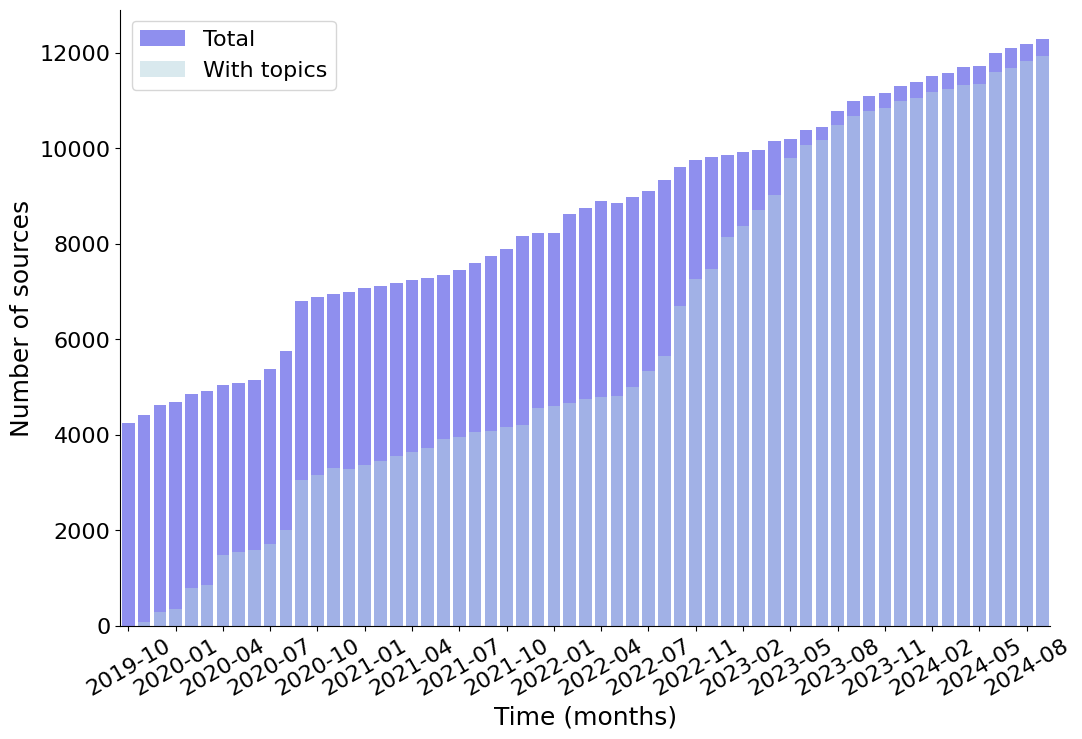

In [16]:
# only take sources with not a NaN in Topics column
topic_domains = df_15[df_15["Topics"].notnull()]

# count of each topic per date
topic_domain_count = \
    topic_domains\
        .groupby("file_date")\
        .size()\
        .reset_index(name="Count")

# count of all sources per date
count_month = \
    df_15\
        .groupby("file_date")\
        .size()\
        .reset_index(name="Total")

# merge the two dataframes
topic_domain_count = \
    topic_domain_count\
        .merge(count_month, 
               on="file_date")

# calculate percentage
topic_domain_count["Prop"] = \
    (topic_domain_count["Count"] / topic_domain_count["Total"] * 100)\
        .round(2)

topic_domain_count["file_month"] = \
    topic_domain_count["file_date"].dt.strftime("%Y-%m")

fig,ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=topic_domain_count,
            x="file_month",
            y="Total",
            color="blue",
            alpha=0.5,
            errorbar=None,
            ax=ax)

sns.barplot(data=topic_domain_count,
            x="file_month",
            y="Count",
            color="lightblue",
            alpha=0.5,
            errorbar=None,
            ax=ax)

#legend
ax.legend(["Total", "With topics"],
            loc="upper left",
            fontsize=16)

plt.xlabel("Time (months)",
              fontsize=18)

#only every few months
ax.set_xticks(ax.get_xticks()[::3])
plt.xticks(rotation=30)
plt.ylabel("Number of sources",
                fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
custom_plots(ax=ax)

plt.savefig(join(FIGURES,
                    "topic_source_over_time.pdf"),
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)

plt.show()

In [17]:
topic_domain_count\
        .groupby("file_date")["Count"]\
        .sum()\
        .reset_index()\
        .sort_values(by="Count",
                        ascending=True)\
        .head(15)

,file_date,Count
0,2019-10-15 01:00:00,4
1,2019-11-15 01:00:00,83
2,2019-12-15 01:00:00,283
3,2020-01-15 01:00:00,349
4,2020-02-15 01:00:00,787
5,2020-03-15 01:00:00,863
6,2020-04-15 01:00:00,1485
7,2020-05-15 01:00:00,1542
8,2020-06-15 01:00:00,1597
9,2020-07-15 01:00:00,1708


In [18]:
# how many of bad domains cover each topic?
bad_domains_time = df_15\
    [topics_df["Rating"] == "N"]\
    ["Domain"].unique()

bad_domains_time_topics = topics_df\
    [topics_df["Domain"].isin(bad_domains_time)]\
    .groupby("Topic")["Domain"]\
    .nunique()\
    .reset_index()

bad_domains_time_topics["%"] = \
    (bad_domains_time_topics["Domain"] / len(bad_domains_time) * 100)\
        .round(2)

bad_topics_bad_sources_time = bad_domains_time_topics\
    .sort_values(by="Domain", ascending=False)\
    .head(7)

bad_topics_bad_sources_time

/tmp/ipykernel_587609/3132569444.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bad_domains_time = df_15\


,Topic,Domain,%
18,Political news,4918,43.42
14,Local news,4509,39.81
10,General news,2339,20.65
1,COVID-19 misinfo,2037,17.98
11,Health news,1771,15.64
3,Conspiracies,1633,14.42
9,General / local news,1010,8.92


## Do topics differ per country?

In [19]:
recent_topics_df_countries = recent_topics_df[recent_topics_df["Country"] != "ALL"]

country_topics = recent_topics_df_countries\
    .groupby(["Country", "Topics"])\
    .size()\
    .reset_index(name="Count")

country_topics["Percentage"] = \
    (country_topics["Count"] / recent_topics_df_countries["Domain"].nunique() * 100)\
        .round(2)

country_topics

,Country,Topics,Count,Percentage
0,AT,Business,2,0.02
1,AT,Celebrity news,6,0.06
2,AT,Conspiracies,5,0.05
3,AT,Entertainment,7,0.06
4,AT,Fashion,1,0.01
...,...,...,...,...
158,US,Religion,66,0.61
159,US,Science,78,0.72
160,US,Sports,378,3.48
161,US,Technology,289,2.66


In [20]:
topic_avg = \
    recent_topics_df_countries\
        .groupby(["Country", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

topic_avg.columns = \
    ["Country", "Topics", "Score", "SD"]

topic_descriptives = \
    pd.merge(
        country_topics, 
        topic_avg, 
        on=["Country", "Topics"])

topic_descriptives =\
    topic_descriptives\
    .sort_values(["Country", "Count"], 
                ascending=[True, False])

topic_descriptives.head(2)

,Country,Topics,Count,Percentage,Score,SD
10,AT,Political news,31,0.29,74.56,31.78
5,AT,General news,17,0.16,82.91,17.96


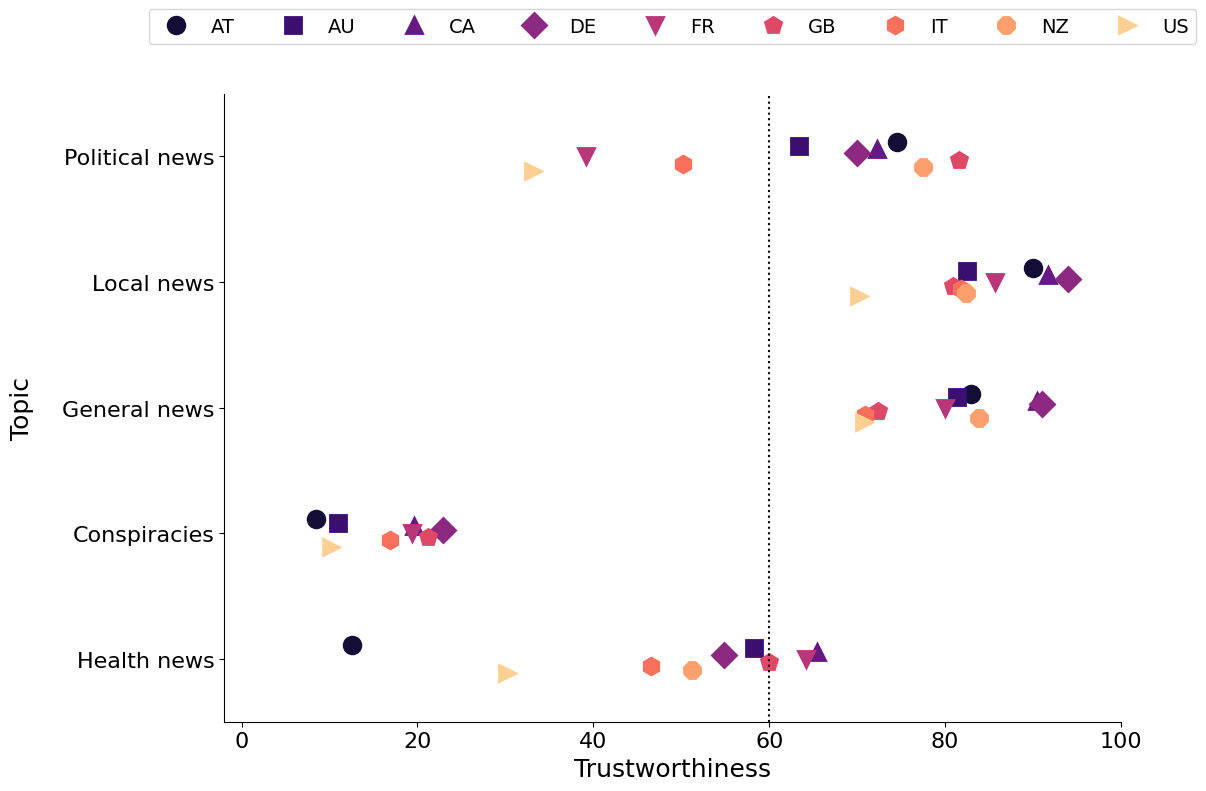

In [21]:
plt.figure(figsize=(12, 8))

top_topics = recent_topic_desc\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(5)

top_topics_country = \
    topic_descriptives[
        topic_descriptives["Topics"].isin(top_topics["Topics"])]


country_markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]

top_topics_country.sort_values(by="Count", 
                                ascending=False,
                                inplace=True)
sns.pointplot(y="Topics", 
            x="Score",
            hue="Country",
            hue_order=sorted(top_topics_country["Country"].unique()),
            data=top_topics_country, 
            dodge=True,
            markers = country_markers,
            markersize = 12,
            linestyle="None",
            palette="magma")

plt.axvline(x=60,
            color="black", 
            linestyle="dotted")

plt.xlim(-2,100)
plt.xlabel("Trustworthiness", fontsize=18)
plt.ylabel("Topic", 
           fontsize=18,
           labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14,
           loc="upper center", 
           bbox_to_anchor=(0.5, 1.15),
           ncol=9)
plt.tight_layout()
custom_plots()

plt.savefig(join(FIGURES, "topics_score_per_country.pdf"),
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)

plt.show() 

In [22]:
# per country, which 5 topics are the most popular?
pop_topics_country = topic_descriptives\
    .groupby("Country")\
    .apply(lambda x: x.nlargest(5, 'Count'))\
    .reset_index(drop=True)

pop_topics_country = \
    pop_topics_country[pop_topics_country["Country"] != "ALL"]

recent_topics_df_country = \
    pd.merge(recent_topics_df, 
             pop_topics_country[['Country', 'Topics']], 
             on=['Country', 'Topics'])

/tmp/ipykernel_587609/4233163687.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'Count'))\


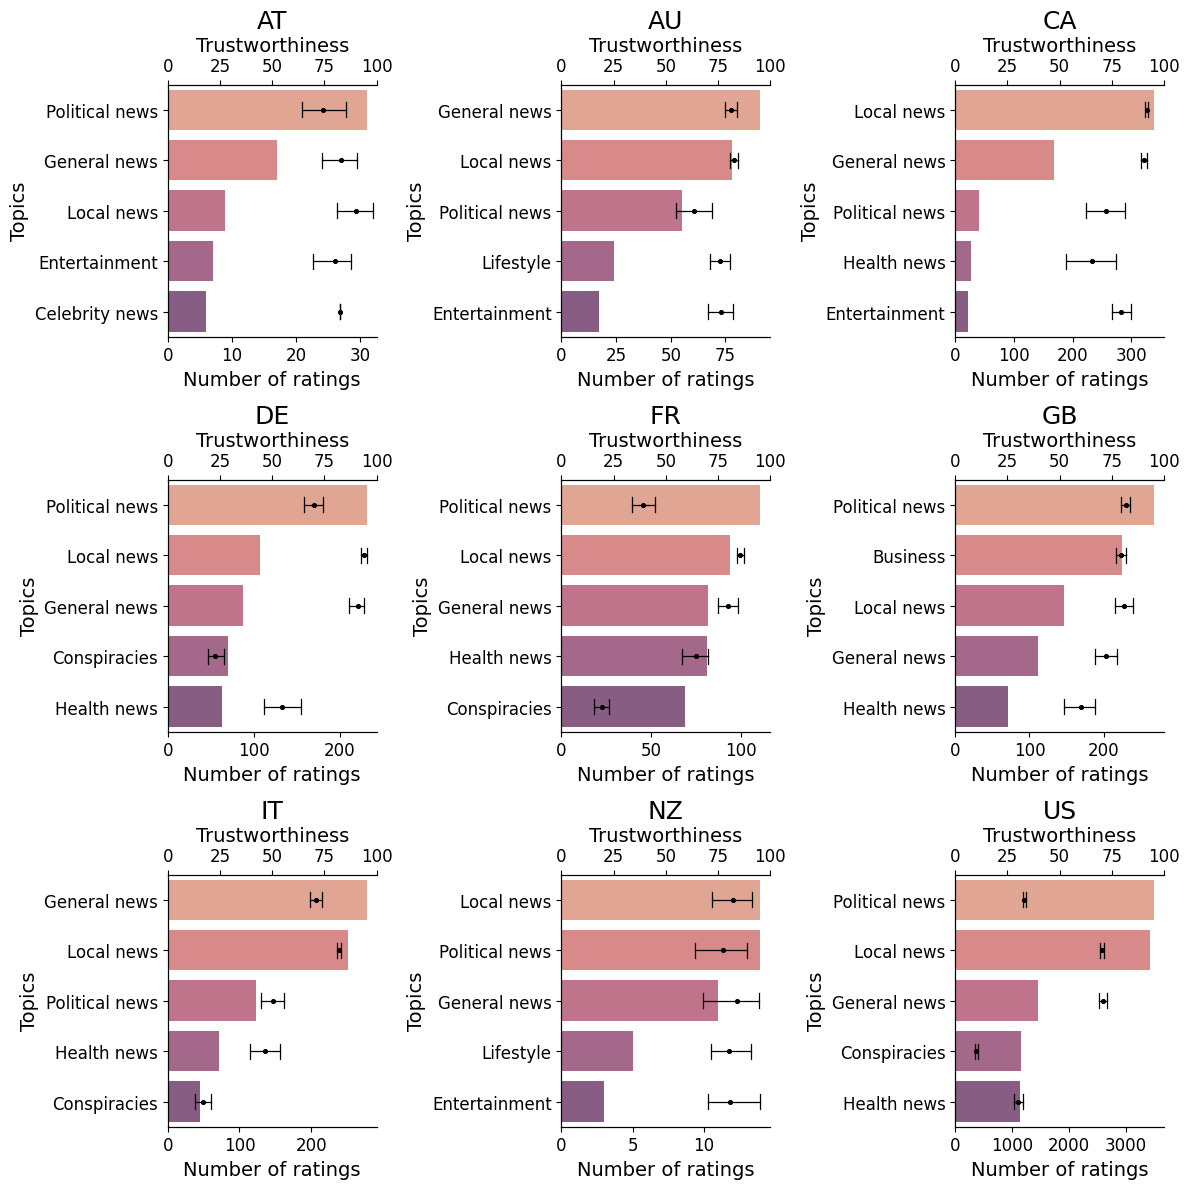

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, sharex=False)
plt.subplots_adjust(hspace=1, wspace=1)

for i, country in enumerate(pop_topics_country["Country"].unique()):
    row = i // 3
    col_in_row = i % 3

    country_topics = pop_topics_country[pop_topics_country["Country"] == country]
    recent_country_topics = recent_topics_df_country[recent_topics_df_country["Country"] == country]

    sns.barplot(data=country_topics, 
                x="Count", 
                y="Topics", 
                hue="Topics", 
                ax=axs[row, col_in_row], 
                alpha=0.8,
                palette="flare")
    axs[row, col_in_row].set_xlabel("Number of ratings", fontsize=14)
    axs[row, col_in_row].xaxis.set_ticks_position("bottom")
    axs[row, col_in_row].xaxis.set_label_position("bottom")
    axs[row, col_in_row].yaxis.set_ticks_position("left")
    axs[row, col_in_row].set_ylabel("Topics", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=12)
    axs[row, col_in_row].tick_params(axis="y", labelsize=12)
    axs[row, col_in_row].grid(False)
    axs[row, col_in_row].spines["right"].set_visible(False)
    axs[row, col_in_row].spines["top"].set_color("black")
    axs[row, col_in_row].spines["bottom"].set_color("black")
    axs[row, col_in_row].spines["left"].set_color("black")

    ax2 = axs[row, col_in_row].twiny()
    sns.pointplot(data=recent_country_topics, 
                  x="Score", 
                  y="Topics", 
                  ax=ax2, 
                  linestyle="none", 
                  color="black",
                  capsize=0.3, 
                  markersize=3, 
                  linewidth=0.9,
                  marker="o")

    ax2.xaxis.set_visible(True)
    ax2.set_xlim(0, 100)
    ax2.xaxis.set_label_position("top")
    ax2.xaxis.set_ticks_position("top")
    ax2.yaxis.set_ticks_position("right")
    ax2.set_xlabel("Trustworthiness", fontsize=14)
    ax2.tick_params(axis="x", labelsize=12)
    ax2.xaxis.tick_top()
    ax2.yaxis.set_visible(False)
    ax2.spines["top"].set_color("black")
    ax2.spines["bottom"].set_color("black")
    ax2.spines["left"].set_color("black")
    ax2.spines["right"].set_visible(False)
    ax2.grid(False)

plt.tight_layout()

plt.savefig(join(FIGURES,
                    "topics_country.pdf"),
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)

plt.show()

In [24]:
#show for topic health information
topic_descriptives[topic_descriptives["Topics"] == "Health news"]

,Country,Topics,Count,Percentage,Score,SD
6,AT,Health news,1,0.01,12.50,NaN
22,AU,Health news,11,0.10,58.32,33.37
40,CA,Health news,27,0.25,65.39,34.03
58,DE,Health news,63,0.58,54.86,36.62
77,FR,Health news,81,0.75,64.18,28.15
97,GB,Health news,71,0.65,59.98,33.09
117,IT,Health news,71,0.65,46.57,31.85
135,NZ,Health news,2,0.02,51.25,37.12
151,US,Health news,1130,10.41,30.21,33.25


In [25]:
topic_descriptives[topic_descriptives["Topics"] == "Political news"]

,Country,Topics,Count,Percentage,Score,SD
10,AT,Political news,31,0.29,74.56,31.78
27,AU,Political news,55,0.51,63.39,32.57
44,CA,Political news,41,0.38,72.28,30.13
64,DE,Political news,231,2.13,70.03,35.73
83,FR,Political news,111,1.02,39.16,29.24
103,GB,Political news,268,2.47,81.55,18.57
123,IT,Political news,123,1.13,50.19,31.23
139,NZ,Political news,14,0.13,77.46,25.83
157,US,Political news,3498,32.21,33.13,24.76


## Do topic labels differ per orientation?

In [26]:
#topics and orientation overlap
topics_orientation = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])\
        .size()\
        .reset_index(name="Count")

mean_scores = \
    recent_topics_df\
        .groupby(["Orientation", "Topics"])["Score"]\
        .agg(["mean", "std"])\
        .reset_index()\
        .round(2)

mean_scores.columns = \
    ["Orientation", "Topics", "Score", "SD"]

topic_orientation_scores = pd.merge(
    topics_orientation, 
    mean_scores, 
    on=["Orientation", "Topics"])

# most popular topics
topic_orientation_scores\
    .sort_values(by="Count", 
                 ascending=False)\
    .head(8)

,Orientation,Topics,Count,Score,SD
32,Right,Political news,2946,26.63,20.02
21,Right,Conspiracies,1162,9.99,11.39
29,Right,Local news,1140,32.98,4.48
26,Right,Health news,693,11.25,14.97
25,Right,General news,431,29.38,24.62
14,Left,Political news,386,60.23,26.01
11,Left,Local news,113,53.77,16.45
7,Left,General news,83,73.73,21.78


In [27]:
#lowest score for right
topic_orientation_scores\
    [topic_orientation_scores["Orientation"] == "Right"]\
    .sort_values(by="Score", 
                 ascending=True)\
    .head(5)

,Orientation,Topics,Count,Score,SD
21,Right,Conspiracies,1162,9.99,11.39
26,Right,Health news,693,11.25,14.97
34,Right,Science,14,23.04,10.61
24,Right,Environment,11,24.05,10.26
30,Right,Military and defense,9,26.33,32.08


In [28]:
# lowest score for left
topic_orientation_scores\
    [topic_orientation_scores["Orientation"] == "Left"]\
    .sort_values(by="Score", 
                 ascending=True)\
    .head(5)

,Orientation,Topics,Count,Score,SD
2,Left,Conspiracies,63,23.77,8.70
12,Left,Military and defense,11,24.50,14.78
8,Left,Health news,27,49.44,28.62
11,Left,Local news,113,53.77,16.45
14,Left,Political news,386,60.23,26.01


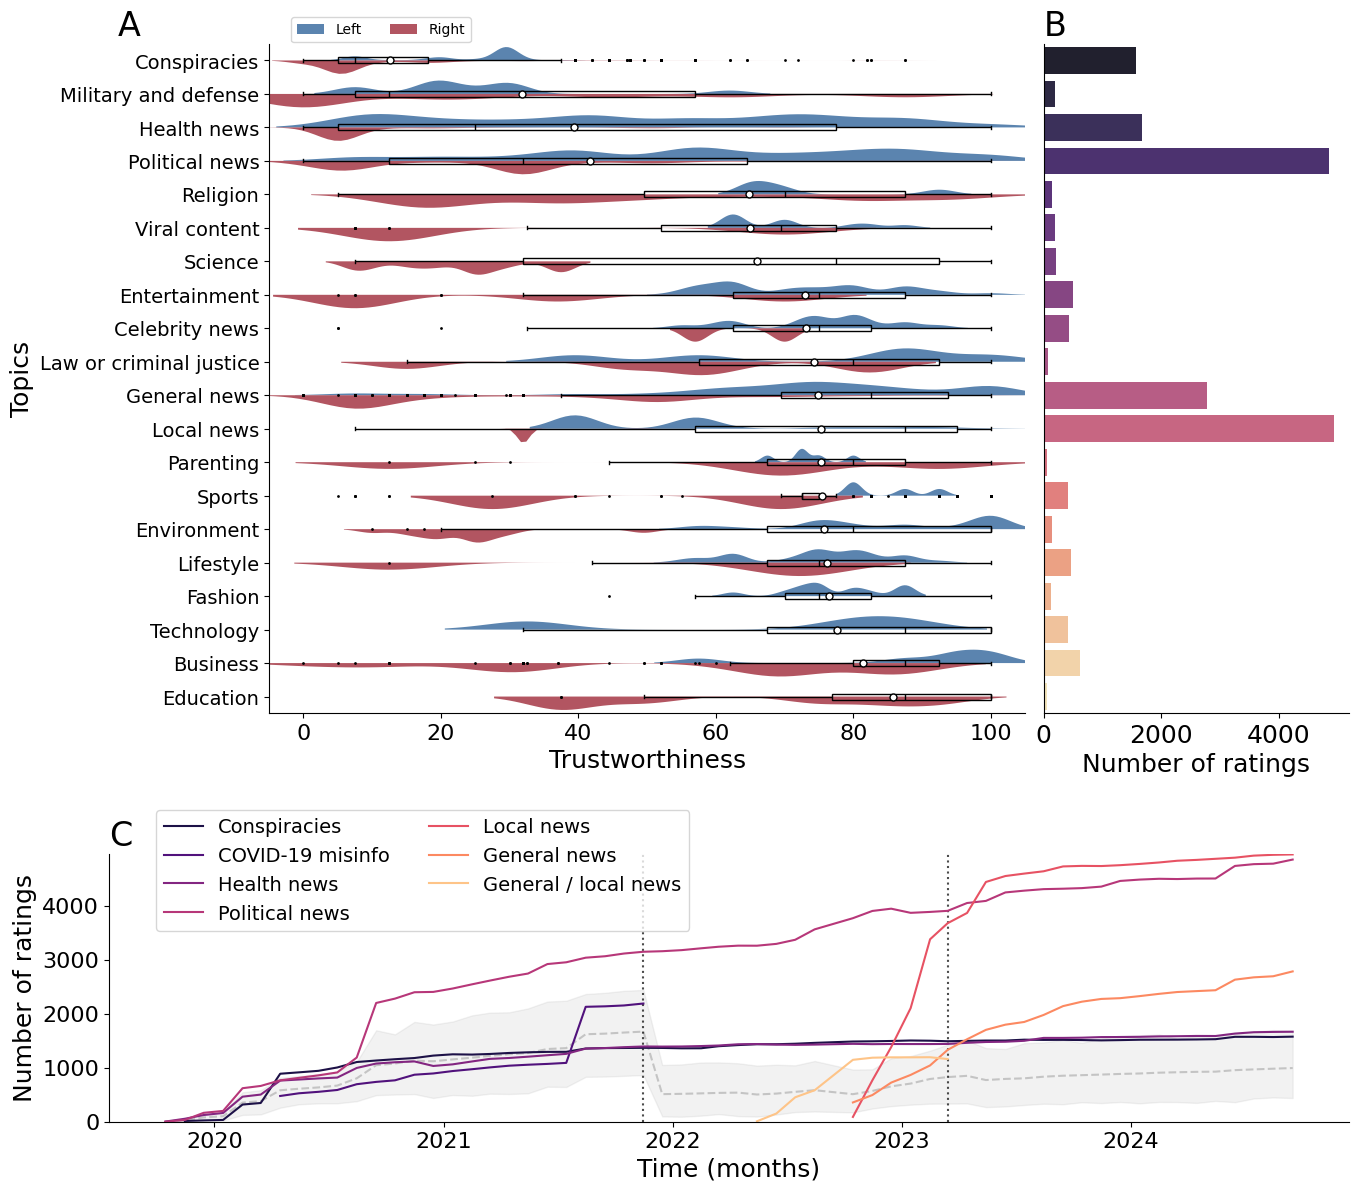

In [29]:
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(2, 2,
              width_ratios=[1.5, 0.5],
              height_ratios=[5, 2],
              hspace=0.3,
              wspace=0.03
              )  

''' SUBPLOT A '''
orientation_palette_after = {"Left": "#2166ac",
                             "Right": "#b2182b"}

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("A", fontsize=24, loc="left",
                x=-0.2, y=1)
              
left_margin = 0.1
pos = ax1.get_position()
ax1.set_position([pos.x0 + left_margin, 
                  pos.y0, 
                  pos.width - left_margin, 
                  pos.height])

recent_topic_desc.sort_values(by="Score",
                                ascending=True,
                                inplace=True)

sns.violinplot(data=recent_topics_df,
                x="Score",
                y="Topics",
                hue="Orientation",
                order=recent_topic_desc["Topics"],
                split=True,
                density_norm="width",
                width=0.8,
                bw_method=0.2,
                alpha=0.8,
                linewidth=1,
                linecolor="none",
                palette=orientation_palette_after,
                inner=None,
                ax=ax1)

sns.boxplot(data=recent_topics_df,
            x="Score",
            y="Topics",
            order=recent_topic_desc["Topics"],
            fliersize=1,
            width=0.18,
            #whis=1,
            boxprops=dict(facecolor="none",
                          linewidth=1,
                          edgecolor="black"),
        
            meanprops=dict(marker="o", 
                           markerfacecolor="white", 
                           markeredgecolor="black",
                           markersize=5),
            showmeans=True,
            linewidth=1,
            color="black",
            ax=ax1)

ax1.set_xlabel("Trustworthiness",
            fontsize=18)
ax1.set_xlim(-5,105)
ax1.set_ylabel("Topics", fontsize=18)
ax1.tick_params(axis="y", labelsize=14)
ax1.tick_params(axis="x", labelsize=16)
ax1.legend(loc="upper left",
           bbox_to_anchor=(0.02,1.05),
           ncol=2)

custom_plots(ax=ax1)


''' SUBPLOT B '''
ax2 = fig.add_subplot(gs[0, 1])

ax2.set_title("B", fontsize=24, loc="left")

sns.barplot(data=recent_topic_desc,
            x="Count",
            y="Topics",
            hue="Topics",
            order=recent_topic_desc["Topics"],
            palette="magma",
            alpha=0.9,
            ax=ax2)

ax2.yaxis.set_visible(False)
ax2.set_xlabel("Number of ratings", 
           fontsize=18)
ax2.set_ylabel("Topics", 
           fontsize=18)
ax2.tick_params(axis='x', 
                labelsize=18)

custom_plots(ax=ax2)

''' SUBPLOT C '''

ax3 = fig.add_subplot(gs[1, :])
ax3.set_title("C", fontsize=24, loc="left")

bad_topics_palette = {
    "Conspiracies": "#762a83",
    "COVID-19 misinfo": "#9970ab",
    "Health news": "#c51b7d",
    "Political news": "#e9a3c9",
    "Local news": "#1b7837",
    "General news":"#4d9221",
    "General / local news": "#7fbf7b"}

bad_topics_bad_sources_time["Topic"] = bad_topics_bad_sources_time["Topic"]\
    .replace({"Conspiracy theories or hoaxes": "Conspiracies",
                "Covid-19 misinformation": "COVID-19 misinfo",
                "Health or medical information": "Health news",
                "Political news or commentary": "Political news"})

bad_topics_list = bad_topics_bad_sources_time["Topic"].to_list()

topic_freq = topics_df\
    .groupby(["file_date", "Topic"])\
    .size()\
    .reset_index(name="Count")

sns.lineplot(x="file_date", 
             y="Count", 
             estimator="mean",
             errorbar=("ci", 95),
             color="grey",
             linestyle="--",
             alpha=0.4,
             err_kws={"alpha":0.1},
             data=topic_freq,
             ax=ax3)

#add vertical line
ax3.axvline(x=pd.Timestamp("2021-11-15"),
            color="black",
            linestyle="dotted",
            alpha=0.7
            )

ax3.axvline(x=pd.Timestamp("2023-03-15"),
            color="black",
            linestyle="dotted",
            alpha=0.7)


sns.lineplot(x="file_date", 
             y="Count", 
             hue="Topic",
             palette="magma",
             hue_order=bad_topics_palette.keys(),
             data=topic_freq[topic_freq["Topic"].isin(bad_topics_list)],
             ax=ax3)


ax3.set_xlabel("Time (months)", 
               fontsize=18)
ax3.set_ylabel("Number of ratings", 
               fontsize=18)
ax3.tick_params(axis="both", 
                labelsize=16)

ax3.set_ylim(0, max(topic_freq["Count"]) + 10)

ax3.legend(fontsize=14, 
           ncol=2,
           loc="upper left",
           bbox_to_anchor=(0.03, 1.2))

custom_plots(ax=ax3)

plt.savefig(join(FIGURES,
                    "topics_panel.pdf"),
                bbox_inches='tight',
                pad_inches=0.1,
                dpi=300)

plt.show()

## Do domains change topic labels?

In [30]:
df_15_countries = df_15[df_15["Country"] != "ALL"]
df_15_topics = df_15_countries[["Domain", "file_date", 
                      "Last Updated",
                      "Score",
                      "Country", "Language", 
                      "Topics"]]

df_15_topics = df_15_topics\
    .groupby(["Domain", "Country", "Language"],
                    group_keys=False)\
    .apply(lambda x: x\
            .sort_values("file_date",
                            ascending=True))\
    .reset_index(drop=True)

/tmp/ipykernel_587609/782828350.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x\


In [31]:
df_15_topics["Topics_Changed"] = \
    df_15_topics\
        .groupby(["Domain", "Country", "Language"])["Topics"]\
            .apply(lambda x: x != x.shift())\
            .reset_index(level=[0, 1, 2], drop=True)

In [32]:
df_15_topics["Updated_diff"] = \
    df_15_topics\
        .groupby(["Domain", "Country", "Language"])["Last Updated"]\
            .diff()

In [33]:
df_15_topics['Actual_Change'] = df_15_topics \
    .apply(lambda row: row["Topics_Changed"] and 
            not pd.isna(row["Updated_diff"]) and 
            not pd.isna(row["Topics"]), axis=1)

In [34]:
#how many domains have changed topics?
topic_change_count = df_15_topics\
    .groupby(["Domain", "Country", "Language"])["Actual_Change"]\
    .sum()\
    .reset_index()

# topic_change_count.sort_values(by="Actual_Change",
#                                ascending=False)\
#    .head(13)